In [1]:
import os
import glob
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, LeakyReLU
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
file=pd.read_csv('F:\\Exprement\\saturn\\time_series\\star_pro\\training_file.csv')
file.corrwith(file['TS4_Target'])

C:\Users\jaisri\AppData\Local\Temp\ipykernel_19684\482311388.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  file.corrwith(file['TS4_Target'])


Price_open     0.999963
Price_high     0.999277
Price_low      0.999099
Price_close    0.998915
FIB_1_MA       0.977136
                 ...   
CM_Stoch_K1    0.014030
CM_Stoch_D1    0.019818
CM_Stoch_K2    0.038751
CM_Stoch_D2    0.046708
Hull_Hist      0.098185
Length: 78, dtype: float64

In [3]:
files='F:\\Exprement\\saturn\\time_series\\star_pro\\'
scaler = StandardScaler()

for a in os.listdir(files):
    name, ext = os.path.splitext(a)
    if ext == ".csv":
        file=pd.read_csv(os.path.join(files,a))
        file=file.drop(['RSI_Spot','MFI_MA','BBWP_MA','PMAR_MA'],axis=1)
        file=file.replace({' -   ': '0', '_': '0', '-': '0', ',': ''}, regex=True)
        file=file.iloc[:,1:43]
        if name == "training_file":
            trainX = scaler.fit_transform(file)
            trainY = trainX [:,33:34]
        elif name == "validation_file":
            val_file = file.iloc[:,1:]
            valX = scaler.fit_transform(file)
            valY = valX [:,33:34]
        elif name == "testing_file":
            test_file = file.iloc[:,1:]
            testX = scaler.fit_transform(file)
            testY = testX [:,33:34]

In [51]:
valX.shape,testX.shape

((83, 90), (39, 90))

In [13]:
win_length=30
batch_size=5

train_generator=TimeseriesGenerator(trainX,trainY,length=win_length,sampling_rate=1,batch_size=batch_size)
val_generator=TimeseriesGenerator(valX,valY,length=win_length,sampling_rate=1,batch_size=batch_size)
test_generator=TimeseriesGenerator(testX,testY,length=win_length,sampling_rate=1,batch_size=batch_size)

train_generator[0]

(array([[[-0.71517283, -0.71548899, -0.71594813, ..., -0.05388786,
          -0.03747162,  0.84656742],
         [-0.71518977, -0.71584857, -0.7161427 , ..., -0.0572988 ,
          -0.04186789,  0.79977668],
         [-0.71526654, -0.71592429, -0.71612256, ..., -0.0552688 ,
          -0.04470642,  0.74789826],
         ...,
         [-0.71718294, -0.71731849, -0.71779983, ..., -0.04368318,
          -0.04768855, -0.93127509],
         [-0.71708103, -0.71698414, -0.71760976, ..., -0.04006372,
          -0.04253769, -0.85462832],
         [-0.71679917, -0.71691474, -0.71731902, ..., -0.0369855 ,
          -0.03799679, -0.77837858]],
 
        [[-0.71518977, -0.71584857, -0.7161427 , ..., -0.0572988 ,
          -0.04186789,  0.79977668],
         [-0.71526654, -0.71592429, -0.71612256, ..., -0.0552688 ,
          -0.04470642,  0.74789826],
         [-0.71533663, -0.7158612 , -0.71610244, ..., -0.04877862,
          -0.04553624,  0.71204642],
         ...,
         [-0.71708103, -0.7169841

In [15]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(win_length, trainX.shape[1]), return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            27392     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 30, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 39,841
Trainable params: 39,841
Non-trai

In [16]:
model.compile(loss=tf.losses.MeanAbsoluteError(),optimizer=tf.optimizers.Adam(1e-4),metrics=[tf.metrics.MeanAbsoluteError()])

In [17]:
# fit the model
history = model.fit(train_generator, validation_data=val_generator, epochs=50, shuffle=False, verbose=1)
model.save('star_pro_weights_5.1.h5')

Epoch 1/50
571/571 [==============================] - 15s 21ms/step - loss: 0.2481 - mean_absolute_error: 0.2481 - val_loss: 0.8821 - val_mean_absolute_error: 0.8821
Epoch 2/50
571/571 [==============================] - 12s 21ms/step - loss: 0.1438 - mean_absolute_error: 0.1438 - val_loss: 0.8258 - val_mean_absolute_error: 0.8258
Epoch 3/50
571/571 [==============================] - 12s 21ms/step - loss: 0.1332 - mean_absolute_error: 0.1332 - val_loss: 0.8322 - val_mean_absolute_error: 0.8322
Epoch 4/50
571/571 [==============================] - 10s 18ms/step - loss: 0.1200 - mean_absolute_error: 0.1200 - val_loss: 0.8389 - val_mean_absolute_error: 0.8389
Epoch 5/50
571/571 [==============================] - 10s 18ms/step - loss: 0.1166 - mean_absolute_error: 0.1166 - val_loss: 0.8372 - val_mean_absolute_error: 0.8372
Epoch 6/50
571/571 [==============================] - 10s 18ms/step - loss: 0.1165 - mean_absolute_error: 0.1165 - val_loss: 0.7936 - val_mean_absolute_error: 0.7936
Epoc

In [18]:
model.evaluate_generator(test_generator,verbose=0)

C:\Users\jaisri\AppData\Local\Temp\ipykernel_10360\267665090.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator,verbose=0)


[0.3193906247615814, 0.3193906247615814]

In [ ]:
model.evaluate_generator(test_generator,verbose=0)

C:\Users\jaisri\AppData\Local\Temp\ipykernel_4728\267665090.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator,verbose=0)


[0.26808178424835205, 0.26808178424835205]

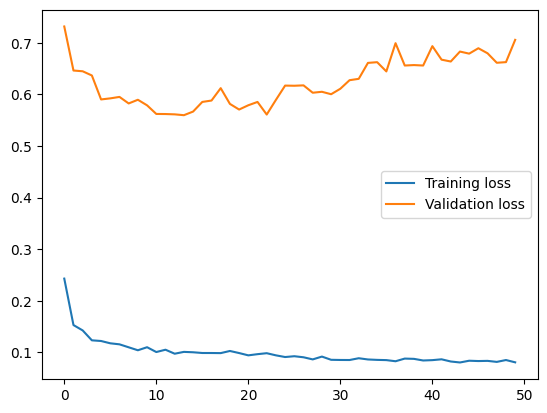

In [21]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.savefig('clo1_43.jpeg')

In [19]:
from tensorflow.keras.models import load_model
model_1=load_model('star_pro_weights_5.1.h5', compile=False)

In [134]:
# testing prediction

In [4]:
trainX.shape[1]

42

In [20]:
pre_df=[]
tru_df=[]

for i in range(len(test_generator)):
    tt=model_1.predict(test_generator[i][0])
    prediction_copies = np.repeat(tt, trainX.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
    pre_df.extend(y_pred_future)
    
    ttt=test_generator[i][1]
    true_copies = np.repeat(ttt, trainX.shape[1], axis=-1)
    y_true_future = scaler.inverse_transform(true_copies)[:,0]
    tru_df.extend(y_true_future)

1/1 [==============================] - 0s 29ms/step


In [60]:
len(pre_df),len(tru_df)

(9, 9)

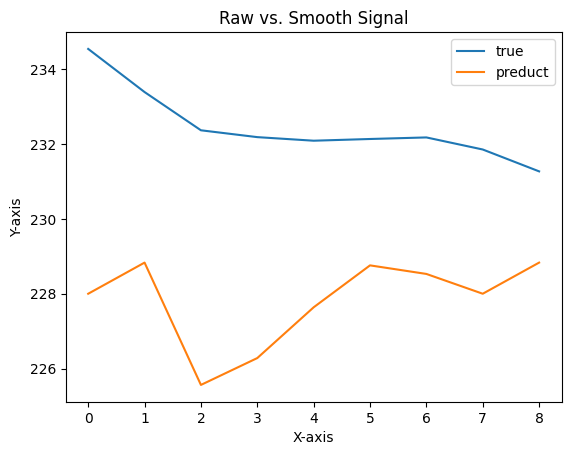

In [24]:
plt.plot(pre_df, label='true')
plt.plot(tru_df, label='preduct')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Raw vs. Smooth Signal')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(pre_df, tru_df))
rms

5.897137143608934

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(pre_df, tru_df))
rms

4.834255116430775

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(pre_df, tru_df))
rms

5.596468798260085

1/1 [==============================] - 0s 90ms/step
rms = 4.834255116430775


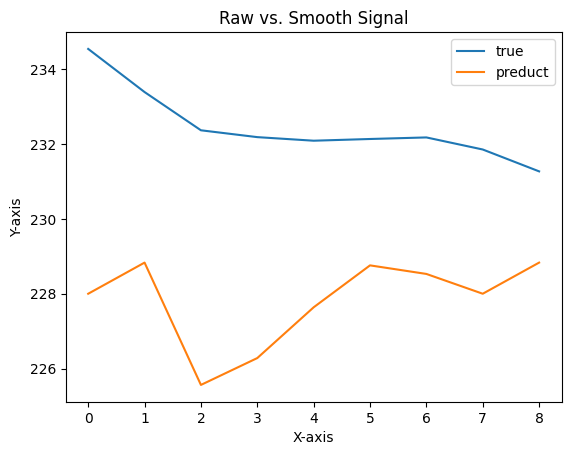

In [26]:
from tensorflow.keras.models import load_model
model_2=load_model('star_pro_weights_4.1.h5', compile=False)

pre_df=[]
tru_df=[]

for i in range(len(test_generator)):
    tt=model_2.predict(test_generator[i][0])
    prediction_copies = np.repeat(tt, trainX.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
    pre_df.extend(y_pred_future)
    
    ttt=test_generator[i][1]
    true_copies = np.repeat(ttt, trainX.shape[1], axis=-1)
    y_true_future = scaler.inverse_transform(true_copies)[:,0]
    tru_df.extend(y_true_future)

from sklearn.metrics import mean_squared_error
from math import sqrt
print('rms =', sqrt(mean_squared_error(pre_df, tru_df)))

plt.plot(pre_df, label='true')
plt.plot(tru_df, label='preduct')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Raw vs. Smooth Signal')
plt.legend()
plt.show()